# AAI-521 Final Project – Group 3  
## 02 – Preprocessing and Vehicle Cropping

**Goal:**  
Convert UA-DETRAC sequences into a compact vehicle classification dataset by:

- Iterating over training sequences
- Cropping each annotated vehicle
- Resizing crops to a fixed resolution
- Encoding classes as integer labels
- Saving the resulting dataset to disk for later model training

This notebook **produces the training dataset** used by the CNN model.

#### Imports & Configuration

In [1]:
import os
import sys
from pathlib import Path
import cv2
import numpy as np
import random
import xml.etree.ElementTree as ET
from tqdm import tqdm
import matplotlib.pyplot as plt

PROJECT_ROOT = Path().resolve().parent
DATA_ROOT = PROJECT_ROOT / "data"

IMAGES_ROOT = DATA_ROOT / "DETRAC-Images"
TRAIN_ANN_ROOT = DATA_ROOT / "DETRAC-Train-Annotations"

TARGET_SIZE = (64, 64)  # (width, height) for CNN inputs
DATA_PATH = DATA_ROOT / "cropped_vehicle_dataset.npz"
SRC_DIR = PROJECT_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from utils_detrac import load_detrac_annotations, VehicleClassifier, predict_vehicle_class

print("Images root:", IMAGES_ROOT)
print("Train annotations root:", TRAIN_ANN_ROOT)
print("Output dataset path:", DATA_PATH)

Images root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Images
Train annotations root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Train-Annotations
Output dataset path: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/cropped_vehicle_dataset.npz


## 1. Generate Cropped Vehicle Dataset

We iterate over all training XML files, match them to image folders,
and generate:

- `images`: array of shape `(N, H, W, 3)` in `[0, 1]` range
- `labels`: integer class IDs
- `class_to_idx`: mapping from vehicle type string → integer

The resulting arrays are saved to `cropped_vehicle_dataset.npz`.

#### Dataset Generation Function

In [2]:
def generate_cnn_training_dataset(
    annotations_root: Path,
    images_root: Path,
    target_size=TARGET_SIZE,
):

    all_images = []
    all_labels = []
    all_metadata = []

    class_to_idx = {}
    next_class_idx = 0

    xml_files = sorted(
        f for f in annotations_root.iterdir()
        if f.suffix.lower() == ".xml"
    )

    for xml_path in tqdm(xml_files, desc="Sequences"):
        seq_id = xml_path.stem  # e.g., "MVI_20011"
        seq_images_dir = images_root / seq_id
        if not seq_images_dir.exists():
            print(f"[WARN] No image folder for {seq_id}, skipping.")
            continue

        annotations = load_detrac_annotations(xml_path)

        for frame_num, targets in annotations.items():
            img_file = seq_images_dir / f"img{frame_num:05d}.jpg"
            if not img_file.exists():
                continue

            frame = cv2.imread(str(img_file))
            if frame is None:
                continue

            h_img, w_img = frame.shape[:2]

            for t in targets:
                x, y, w, h = t["bbox"]
                cls = t["class"]

                # Clamp bounding box to image bounds
                x1 = max(int(x), 0)
                y1 = max(int(y), 0)
                x2 = min(int(x + w), w_img)
                y2 = min(int(y + h), h_img)

                if x2 <= x1 or y2 <= y1:
                    continue

                crop = frame[y1:y2, x1:x2]
                crop = cv2.resize(crop, target_size)
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                crop = crop.astype("float32") / 255.0

                if cls not in class_to_idx:
                    class_to_idx[cls] = next_class_idx
                    next_class_idx += 1

                label_idx = class_to_idx[cls]

                all_images.append(crop)
                all_labels.append(label_idx)
                all_metadata.append({
                    "seq_id": seq_id,
                    "frame_num": frame_num,
                    "class": cls,
                    # NEW: useful extra info, inspired by base_model
                    "image_path": str(img_file),
                    "bbox": (int(x1), int(y1), int(x2), int(y2)),
                    "label_idx": int(label_idx),
                })


    images = np.stack(all_images, axis=0)
    labels = np.array(all_labels, dtype=np.int64)

    print("Dataset size:", images.shape[0])
    print("Classes:", class_to_idx)

    return images, labels, class_to_idx, all_metadata

#### Run Generation & Save

In [3]:
# Make sure DATA_PATH is a Path
DATA_PATH = Path(DATA_PATH)

if DATA_PATH.exists():
    print(f"✅ Cropped dataset already exists at {DATA_PATH}. Skipping generation.")
else:
    images, labels, class_to_idx, metadata = generate_cnn_training_dataset(
        TRAIN_ANN_ROOT,
        IMAGES_ROOT,
        target_size=TARGET_SIZE,
    )

    np.savez_compressed(
        DATA_PATH,
        images=images,
        labels=labels,
        class_to_idx=class_to_idx,
        metadata=np.array(metadata, dtype=object),
    )

    print(f"💾 Saved cropped dataset to {DATA_PATH}")

✅ Cropped dataset already exists at /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/cropped_vehicle_dataset.npz. Skipping generation.


## 2. Quick Sanity Check on the Cropped Dataset

We visualize a few random crops with their labels
to confirm the dataset looks correct.

#### Quick Sanity Check

Loading dataset from /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/cropped_vehicle_dataset.npz


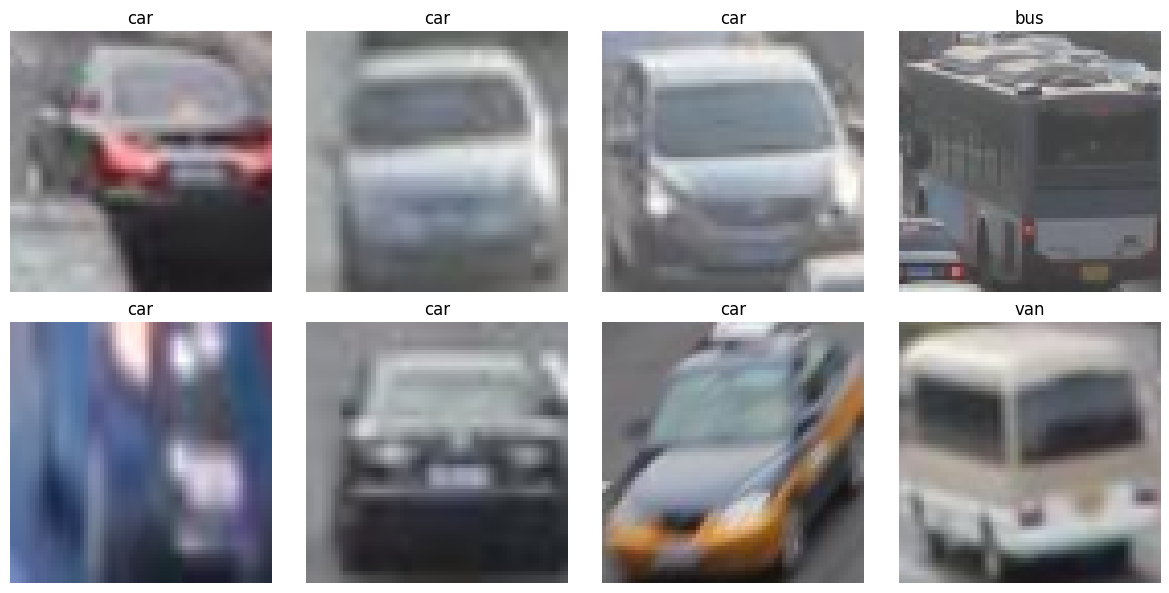

In [5]:
# -------------------------
# Load the dataset
# -------------------------
if DATA_PATH.exists():
    print(f"Loading dataset from {DATA_PATH}")
    data = np.load(DATA_PATH, allow_pickle=True)
    images = data["images"]
    labels = data["labels"]
    class_to_idx = data["class_to_idx"].item()
    metadata = data["metadata"]
else:
    raise FileNotFoundError(
        f"{DATA_PATH} does not exist. Run the generation cell first."
    )

# Reverse lookup: index → class_name
idx_to_class = {v: k for k, v in class_to_idx.items()}

# -------------------------
# Show sample images
# -------------------------
n_show = 8
indices = random.sample(range(len(images)), k=n_show)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for ax, i in zip(axes, indices):
    ax.imshow(images[i])
    label = labels[i]
    ax.set_title(idx_to_class[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

## 3. Summary

- Generated a cropped vehicle classification dataset from UA-DETRAC:
  - Total samples: `N =` _(see above output)_
  - Image size: `64 × 64 × 3`
  - Classes: car, bus, van, truck, etc.
- Saved the dataset to `data/cropped_vehicle_dataset.npz`.

Next step: train a CNN classifier using this dataset (Notebook 03).